# Stackplot updating

### List of wetland edits

push to github every time you change one of these!!!!
- wofs bit flags - include low angle wofs -pushed
- ditch no data values
- check for 90% coverage of shape, not just load
- if no data, redo load with no 90% thing, then monthly aggregate before checking for coverage
-  tighten graph and increase text size


- wofs - plot to see what the actual values are in between 
- wofs - fill gaps with ndwi
- wofs - plot against surface reflectance

- use bens awesome stats code to gap fill?

- rolling average for inference?
        

### import modules


In [1]:
import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import xarray as xr

from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from datacube.storage import masking
from datacube.utils import geometry
from digitalearthau.utils import wofs_fuser

sys.path.append('/g/data/r78/rjd547/jupyter_notebooks/dea-notebooks/10_Scripts')
import DEADataHandling, DEAPlotting, TasseledCapTools

dc = datacube.Datacube(app='tci and wofs')

global Output_dir
Output_dir = '/g/data/r78/rjd547/Ramsar_Wetlands/Ramsar_Outputs_2/'

### Set up polygon

In [2]:
def get_RAMSAR_polyName(shapefile):
    ''' function designed specifically for the RAMSAR wetlands australia shapefile. Takes the shapefile and extracts
    the ramsar name, wetland name and objectID from the ESRI shapefile format and turns it into a useful string for our output.
    :Inputs: shapefile with RAMSAR_NAM, WETLAND_NA, and OBJECTID as properties. 
    Author: Bex Dunn Last Edited: March 2019'''
    # get the ramsar name from the shapes 
    RAMSAR_NAME = '_'.join(shapefile['properties']['RAMSAR_NAM'].split(' '))
    WETLAND_NAME = '_'.join(shapefile['properties']['WETLAND_NA'].split(' '))
    STATE = '_'.join(shapefile['properties']['STATE'].split(' ')) 
    ID = shapefile['id']
    polyName = f'{RAMSAR_NAME}-{WETLAND_NAME}-{STATE}-{ID}'
    print(f'processing polygon {polyName}')
    return(polyName)

### change the path here if you want a different polygon

In [3]:
poly_path = '/g/data/r78/rjd547/Ramsar_Wetlands/shapefiles/ExplodedRAMSAR.shp'

In [4]:
#open the polygon and manually select your favourite polygon the lazy way
with fiona.open(poly_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        #first_geometry = next(iter(shapes))['geometry']
        #geom = geometry.Geometry(first_geometry, crs=crs)
        for feature in shapes:
            #print(feature['properties']['WETLAND_NA'])
            if feature['properties']['WETLAND_NA']=='Lake Charm':
                lake_charm =feature
                lake_charm_geometry = lake_charm['geometry']
                geom = geometry.Geometry(lake_charm_geometry, crs=crs)

In [5]:
def get_masked_ls578_data(query, geom):
    '''create a function that takes in the masked proportion, query and geometry and returns the fully masked surface reflectance data'''
    ## Set up datasets
    #set cloudmasking threshold and load landsat nbart data
    landsat_masked_prop = 0.90
    ls578_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart',
            masked_prop=landsat_masked_prop)

    ### mask the data with our original polygon to remove extra data 

    data = ls578_ds
    mask = rasterio.features.geometry_mask([geom.to_crs(data.geobox.crs)for geoms in [geom]],
                                               out_shape=data.geobox.shape,
                                               transform=data.geobox.affine,
                                               all_touched=False,
                                               invert=False)

    #for some reason xarray is not playing nicely with our old masking function
    mask_xr = xr.DataArray(mask, dims = ('y','x'))
    ls578_ds = data.where(mask_xr==False)
    return ls578_ds, mask_xr

In [6]:
def get_masked_tcw(sr_data, mask, threshold=-350):
    '''uses TasseledCapTools and an input threshold (defaults to -350) to create masked over-threshold tasseled cap '''

    #transform the nbart into tci
    tci = TasseledCapTools.thresholded_tasseled_cap(ls578_ds,wetness_threshold=-350, drop=True , drop_tc_bands=True)

    #select only finite values (over threshold values)
    tcw = xr.ufuncs.isfinite(tci.wetness_thresholded)

    # #reapply the polygon mask
    tcw = tcw.where(mask_xr==False)

    return tcw

### Set up query

In [7]:
query = {'geopolygon': geom,
         'time': ('1993-01-01', '1994-01-01')
         }

### Load data sets, where 90% of data is unmasked

#### Landsat data

In [8]:
#load and mask data. selecting data with more than 90% clear for the geobox around the polygon... #FIXME
ls578_ds, mask_xr= get_masked_ls578_data(query,geom)

Loading ls5
    Loading 16 filtered ls5 timesteps
Loading ls7
    Skipping ls7; no valid data for query
Loading ls8
    Skipping ls8; no valid data for query
Returning ls5 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [9]:
#calculate tasselled cap wetness within masked AOI
tcw = get_masked_tcw(ls578_ds, mask_xr, threshold=-350)

In [10]:

#wofls = dc.load(product = 'wofs_albers', like=ls578_ds, fuse_func=wofs_fuser)
wofls = dc.load(product = 'wofs_albers',fuse_func=wofs_fuser, **query)

#first, match tcw and wofs

In [11]:
wofls = wofls.where(wofls.time==tcw.time)

In [12]:
# #reapply the polygon mask
wofls = wofls.where(mask_xr==False)

In [13]:
wet_wofs = wofls.where(wofls.water==128)

In [14]:
shadow_wofs = wofls.where(wofls.water== 136) #use bit values for wet (128) and terrain/low-angle (8)

### load in fractional cover data

In [16]:
#load the data according to our query
#choose a mask proportion to look for a clear timestep
fc_ds = DEADataHandling.load_clearlandsat(dc, query,product='fc',masked_prop=0.90)

Loading ls5
    Loading 16 filtered ls5 timesteps
Loading ls7
    Skipping ls7; no valid data for query
Loading ls8
    Skipping ls8; no valid data for query
Returning ls5 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


### mask FC with polygon

In [17]:
fc_ds = fc_ds.where(mask_xr==False)

### mask FC with wetness

In [18]:
fc_ds_noTCW=fc_ds.where(tcw==False)
#match timesteps
fc_ds_noTCW= fc_ds_noTCW.where(fc_ds_noTCW.time==tcw.time)

### Calculate the dominant fraction for each pixel in Fractional Cover

In [19]:
#drop data percentage and Unmixing Error
fc_tester = fc_ds_noTCW.drop(['data_perc','UE'])

#following robbi's advice, cast the dataset to a dataarray
maxFC = fc_tester.to_array(dim='variable', name='maxFC')

#turn FC array into integer only as nanargmax doesn't seem to handle floats the way we want it to
FC_int = maxFC.astype('int8')

#use numpy.nanargmax to get the index of the maximum value along the variable dimension
#BSPVNPV=np.nanargmax(FC_int, axis=0)
BSPVNPV=FC_int.argmax(dim='variable')

FC_mask=xr.ufuncs.isfinite(maxFC).all(dim='variable')

# #re-mask with nans to remove no-data
BSPVNPV=BSPVNPV.where(FC_mask)

### Calculate number of pixels in area of interest

In [20]:
#number of pixels in area of interest
pixels = (mask_xr==0).sum(dim=['x','y'])

In [21]:
#count number of tcw pixels
tcw_pixel_count = tcw.sum(dim=['x','y'])

In [22]:
FC_dominant = xr.Dataset({
    'BS': (BSPVNPV==0).where(FC_mask),
    'PV': (BSPVNPV==1).where(FC_mask),
    'NPV': (BSPVNPV==2).where(FC_mask),
})

In [23]:
#number of pixels in area of interest
pixels = (mask_xr==0).sum(dim=['x','y'])

In [47]:
#count number of wofs pixels
wofs_pixels = wet_wofs.water.count(dim=['x','y'])+shadow_wofs.water.count(dim=['x','y'])
wofs_pixels

<xarray.DataArray 'water' (time: 16)>
array([9190, 9126, 9326, 9260, 9246, 9306, 9275, 9265, 2901, 9238, 9195, 9155,
       8541, 9550, 9284, 9259])
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01T23:36:52.500000 ... 1993-12-19T23:37:09.500000

In [24]:
# #count number of wofs pixels
# wofs_pixels = wet_wofs.water.sum(dim=['x','y'])/128

In [48]:
#count percentage of area of wofs
wofs_area_percent = (wofs_pixels/pixels)*100
#wofs_area_percent

In [49]:
#count number of tcw pixels
tcw_pixel_count = tcw.sum(dim=['x','y'])

In [50]:
#calculate percentage area wet
tcw_area_percent = (tcw_pixel_count/pixels)*100

In [51]:
#calculate wet not wofs
tcw_less_wofs = tcw_area_percent-wofs_area_percent

In [52]:
#drop data percentage and Unmixing Error
fc_tester = fc_ds_noTCW.drop(['data_perc','UE'])

In [53]:
#following robbi's advice, cast the dataset to a dataarray
maxFC = fc_tester.to_array(dim='variable', name='maxFC')

In [54]:
#turn FC array into integer only as nanargmax doesn't seem to handle floats the way we want it to
FC_int = maxFC.astype('int8')

In [55]:
#use numpy.nanargmax to get the index of the maximum value along the variable dimension
#BSPVNPV=np.nanargmax(FC_int, axis=0)
BSPVNPV=FC_int.argmax(dim='variable')

In [56]:
#work out where we have actual values!
FC_mask=xr.ufuncs.isfinite(maxFC).all(dim='variable')

# #re-mask with nans to remove no-data
BSPVNPV=BSPVNPV.where(FC_mask)

In [57]:
#restack the Fractional cover dataset all together
FC_dominant = xr.Dataset({
    'BS': (BSPVNPV==0).where(FC_mask),
    'PV': (BSPVNPV==1).where(FC_mask),
    'NPV': (BSPVNPV==2).where(FC_mask),
})

In [58]:
FC_count = FC_dominant.sum(dim=['x','y'])

In [59]:
#Fractional cover pixel count method
#Get number of FC pixels, divide by total number of pixels per polygon
#Work out the number of nodata pixels in the data, so that we can graph the variables by number of observed pixels.

Bare_soil_percent=(FC_count.BS/pixels)*100

Photosynthetic_veg_percent=(FC_count.PV/pixels)*100

NonPhotosynthetic_veg_percent=(FC_count.NPV/pixels)*100

NoData = 100 - wofs_area_percent- tcw_less_wofs - Photosynthetic_veg_percent - NonPhotosynthetic_veg_percent - Bare_soil_percent

In [60]:
NoDataPixels = (NoData/100) * pixels 

In [61]:
#Fractional cover pixel count method
#Get number of FC pixels, divide by total number of pixels per polygon

Bare_soil_percent2=(FC_count.BS/(pixels - NoDataPixels))*100

Photosynthetic_veg_percent2=(FC_count.PV/(pixels- NoDataPixels))*100

NonPhotosynthetic_veg_percent2=(FC_count.NPV/(pixels- NoDataPixels))*100

In [62]:
#count percentage of area of wofs
wofs_area_percent2 = (wofs_pixels/(pixels - NoDataPixels))*100
#wofs_area_percent

In [63]:
#count number of tcw pixels
tcw_pixel_count2 = tcw.sum(dim=['x','y'])

In [64]:
#calculate percentage area wet
tcw_area_percent2 = (tcw_pixel_count2/(pixels - NoDataPixels))*100

In [65]:
#calculate wet not wofs
tcw_less_wofs2 = tcw_area_percent2-wofs_area_percent2

<Figure size 432x288 with 0 Axes>

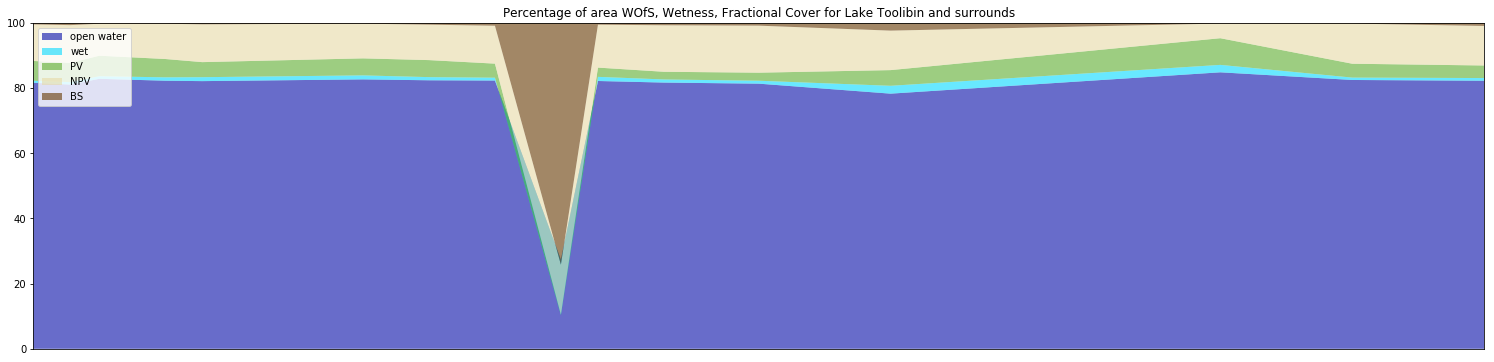

plot created for Lake Toolibin and surrounds
wrote output data to file /g/data/r78/rjd547/Ramsar_Wetlands/Ramsar_Outputs_2/Lake Toolibin and surrounds.csv


In [66]:
#set up color palette
pal = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"]]       
#try and figure out what the error is on one of the plots
#make a stacked area plot
plt.clf()
plt.figure(figsize = (26,6))
plt.stackplot(wofs_area_percent.time.values, 
              wofs_area_percent2, 
              tcw_less_wofs2, 
              Photosynthetic_veg_percent2, 
              NonPhotosynthetic_veg_percent2,
              Bare_soil_percent2,
              labels=['open water',
                      'wet',
                      'PV',
                      'NPV',
                      'BS',
                     ], colors=pal, alpha = 0.6)
polyName = 'Lake Toolibin and surrounds'
plt.title(f'Percentage of area WOfS, Wetness, Fractional Cover for {polyName}')


#set date ticks every year

years = mdates.YearLocator(1)
yearsFmt = mdates.DateFormatter('%Y')

#set axis limits to the min and max
plt.axis(xmin = wofs_area_percent.time[0].data, xmax = wofs_area_percent.time[-1].data, ymin = 0, ymax = 100)
ax = plt.gca()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
#add a legend and a tight plot box
plt.legend(loc='upper left')
#plt.tight_layout()

#create rectangle borders for no-data times (SLC-off only)
LS5_8_gap_start = datetime(2011,11,1)
LS5_8_gap_end = datetime(2013,4,1)

# convert to matplotlib date representation
gap_start = mdates.date2num(LS5_8_gap_start)
gap_end = mdates.date2num(LS5_8_gap_end)
gap = gap_end - gap_start

#set up rectangle
slc_rectangle= Rectangle((gap_start,0), gap, 100,alpha = 0.5, facecolor=sns.xkcd_rgb['white'],
             edgecolor=sns.xkcd_rgb['white'], hatch="////",linewidth=2)
ax.add_patch(slc_rectangle)


#save the figure
plt.savefig(f'{Output_dir}{polyName}.png')#, transparent=True)
plt.show()
print(f'plot created for {polyName}')

#make a new dataframe using the data from the xarray of wofs area for the polygon

### start setup of dataframe by adding only one dataset
WOFS_df = pd.DataFrame(data=wofs_area_percent.data, index=wofs_area_percent.time.values,columns=['wofs_area_percent'])

#add data into pandas dataframe for export
WOFS_df['tcw_area_percent']=tcw_less_wofs.data
WOFS_df['PV_percent']=Photosynthetic_veg_percent.data
WOFS_df['NPV_percent']=NonPhotosynthetic_veg_percent.data
WOFS_df['BS_percent']=Bare_soil_percent.data
WOFS_df['Cloud_percent']=NoData.data

#call the composite dataframe something sensible, like PolyDrill
PolyDrill_df = WOFS_df.round(2)

#save the csv of the output data used to create the stacked plot for the polygon drill
PolyDrill_df.to_csv(f'{Output_dir}{polyName}.csv')
print(f'wrote output data to file {Output_dir}{polyName}.csv')

## Plot code for polygons for terria map

<Figure size 432x288 with 0 Axes>

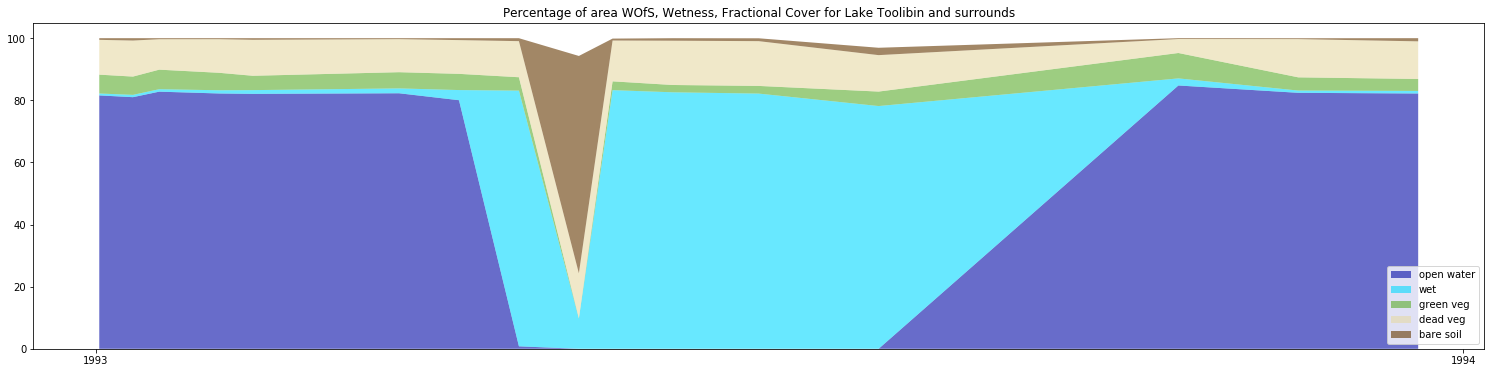

plot created for Lake Toolibin and surrounds


In [44]:
#set up color palette
        pal = [sns.xkcd_rgb["cobalt blue"],
               sns.xkcd_rgb["neon blue"],
               sns.xkcd_rgb["grass"],
               sns.xkcd_rgb["beige"],
               sns.xkcd_rgb["brown"]]       
        #try and figure out what the error is on one of the plots
        #make a stacked area plot
        plt.clf()
        plt.figure(figsize = (26,6))
        plt.stackplot(wofs_area_percent.time.values, 
                      wofs_area_percent, 
                      tcw_less_wofs, 
                      Photosynthetic_veg_percent, 
                      NonPhotosynthetic_veg_percent,
                      Bare_soil_percent,
                     labels=['open water',
                      'wet',
                      'green veg',
                      'dead veg',
                      'bare soil',
                     ], colors=pal, alpha = 0.6)


        plt.title(f'Percentage of area WOfS, Wetness, Fractional Cover for {polyName}')


        #set date ticks every year

        years = mdates.YearLocator(1)
        yearsFmt = mdates.DateFormatter('%Y')

        #set axis limits to the min and max
        #plt.axis(xmin = wofs_area_percent.time[0].data, xmax = wofs_area_percent.time[-1].data, ymin = 0, ymax = 100)
        ax = plt.gca()
        ax.xaxis.set_major_locator(years)
        ax.xaxis.set_major_formatter(yearsFmt)
        #add a legend and a tight plot box
        plt.legend(loc='lower right')
        #plt.tight_layout()

        #create rectangle borders for no-data times (SLC-off only)
        LS5_8_gap_start = datetime(2011,11,1)
        LS5_8_gap_end = datetime(2013,4,1)

        # convert to matplotlib date representation
        gap_start = mdates.date2num(LS5_8_gap_start)
        gap_end = mdates.date2num(LS5_8_gap_end)
        gap = gap_end - gap_start

        #set up rectangle
        slc_rectangle= Rectangle((gap_start,0), gap, 100,alpha = 0.5, facecolor=sns.xkcd_rgb['white'],
                     edgecolor=sns.xkcd_rgb['white'], hatch="////",linewidth=2)
        ax.add_patch(slc_rectangle)


        #save the figure
        plt.savefig(f'{Output_dir}{polyName}.png')#, transparent=True)
        plt.show()
        print(f'plot created for {polyName}')


## test area plot

In [45]:
#set up color palette for just the fractional cover
fc_colors = [sns.xkcd_rgb["brown"], #0
       sns.xkcd_rgb["grass"], #1
       sns.xkcd_rgb["beige"]] #2
fc_norm=matplotlib.colors.BoundaryNorm([0,1,2,3],3)

NameError: name 'matplotlib' is not defined

In [ ]:
#thresholded TCW is boolean type, so need a two-step color map with transparent and a color
tcw_colors = ('#00000000',sns.xkcd_rgb["neon blue"]) #neon blue to transparent
#we use "NoNorm" because our data should only come in 0 and 1s
tcw_norm = matplotlib.colors.NoNorm(0,1)

In [ ]:
#thresholded wofs is boolean type, so need a two-step color map with transparent and a color
wofs_colors = ('#00000000',sns.xkcd_rgb["cobalt blue"]) #cobalt blue to transparent
#use the same Norm as tcw
wofs_norm = tcw_norm

In [ ]:
import datetime
scene_day= np.datetime_as_string(tcw.isel(time=scene).time.values, unit='D')


In [ ]:
#plot the results to check they look roughly like what we are expecting
plt.clf()
plt.imshow(BSPVNPV[scene],cmap=matplotlib.colors.ListedColormap(colors=fc_colors), norm=fc_norm, alpha =0.7)

###us numpy to turn data into a float so the colormap doesn't break
plt.imshow(tcw.isel(time=scene).astype(np.float32), cmap=matplotlib.colors.ListedColormap(colors=tcw_colors), norm=tcw_norm, alpha =0.6)
plt.imshow(wet_wofs.water.isel(time=scene),cmap=matplotlib.colors.ListedColormap(colors =wofs_colors), norm = wofs_norm, alpha =0.5 )
#note shadow wofs not plotted here!!!!!!! #FIXME
plt.tick_params(
    axis= 'both', #both x and y
    which = 'both', # both major and minor ticks
    bottom = False, #turn off ticks on bottom
    left = False, # turn off ticks on left
    labelbottom = False, #turn off ticklabels on the bottom
    labelleft = False        #turn of ticklabels on the left
    )
plt.title(f'WOfS, Wetness, Fractional Cover for {scene_day}')
plt.tight_layout()
#plt.savefig(f'/g/data/r78/rjd547/Macquarie_Marsh/Mac_FC_{scene_day}.png')